In [31]:
import numpy as np
import os, glob

import matplotlib.pyplot as plt

from PIL import Image

from scipy.stats import ttest_ind

#torch
import torch
import torchvision

from torch.utils.data import IterableDataset, DataLoader
from torchvision import transforms

#captum
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients

from captum.concept import TCAV
from captum.concept import Concept

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str

In [3]:
# Method to normalize an image to Imagenet mean and standard deviation
def transform(img):

    return transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )(img)

In [4]:
def get_tensor_from_filename(filename):
    img = Image.open(filename).convert("RGB")
    return transform(img)


def load_image_tensors(class_name, root_path='/content/drive/MyDrive/data/tcav/image/concept/', transform=True):
    path = os.path.join(root_path, class_name)
    filenames = glob.glob(path + '/*.jpg')

    tensors = []
    for filename in filenames:
        img = Image.open(filename).convert('RGB')
        tensors.append(transform(img) if transform else img)

    return tensors


In [5]:
def assemble_concept(name, id, concepts_path="/content/drive/MyDrive/data/tcav/image/concept/"):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    concept_iter = dataset_to_dataloader(dataset)

    return Concept(id=id, name=name, data_iter=concept_iter)


In [6]:
concepts_path = "/content/drive/MyDrive/data/tcav/image/concept/"

stripes_concept = assemble_concept("striped", 0, concepts_path=concepts_path)
zigzagged_concept = assemble_concept("zigzagged", 1, concepts_path=concepts_path)
dotted_concept = assemble_concept("dotted", 2, concepts_path=concepts_path)


random_0_concept = assemble_concept("random_1", 3, concepts_path=concepts_path)
random_1_concept = assemble_concept("random_2", 4, concepts_path=concepts_path)

In [7]:
def assemble_concept(name, id, concepts_path="/content/drive/MyDrive/data/tcav/image/concept/"):
    concept_path = os.path.join(concepts_path, name) + "/"

    # 🟨 Check if the folder exists and has images
    files = glob.glob(concept_path + '*.jpg')
    print(f"Concept '{name}' found {len(files)} image(s) in {concept_path}")

    # Proceed as before
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    concept_iter = dataset_to_dataloader(dataset)

    return Concept(id=id, name=name, data_iter=concept_iter)
striped_concept = assemble_concept("striped", 0)

Concept 'striped' found 120 image(s) in /content/drive/MyDrive/data/tcav/image/concept/striped/


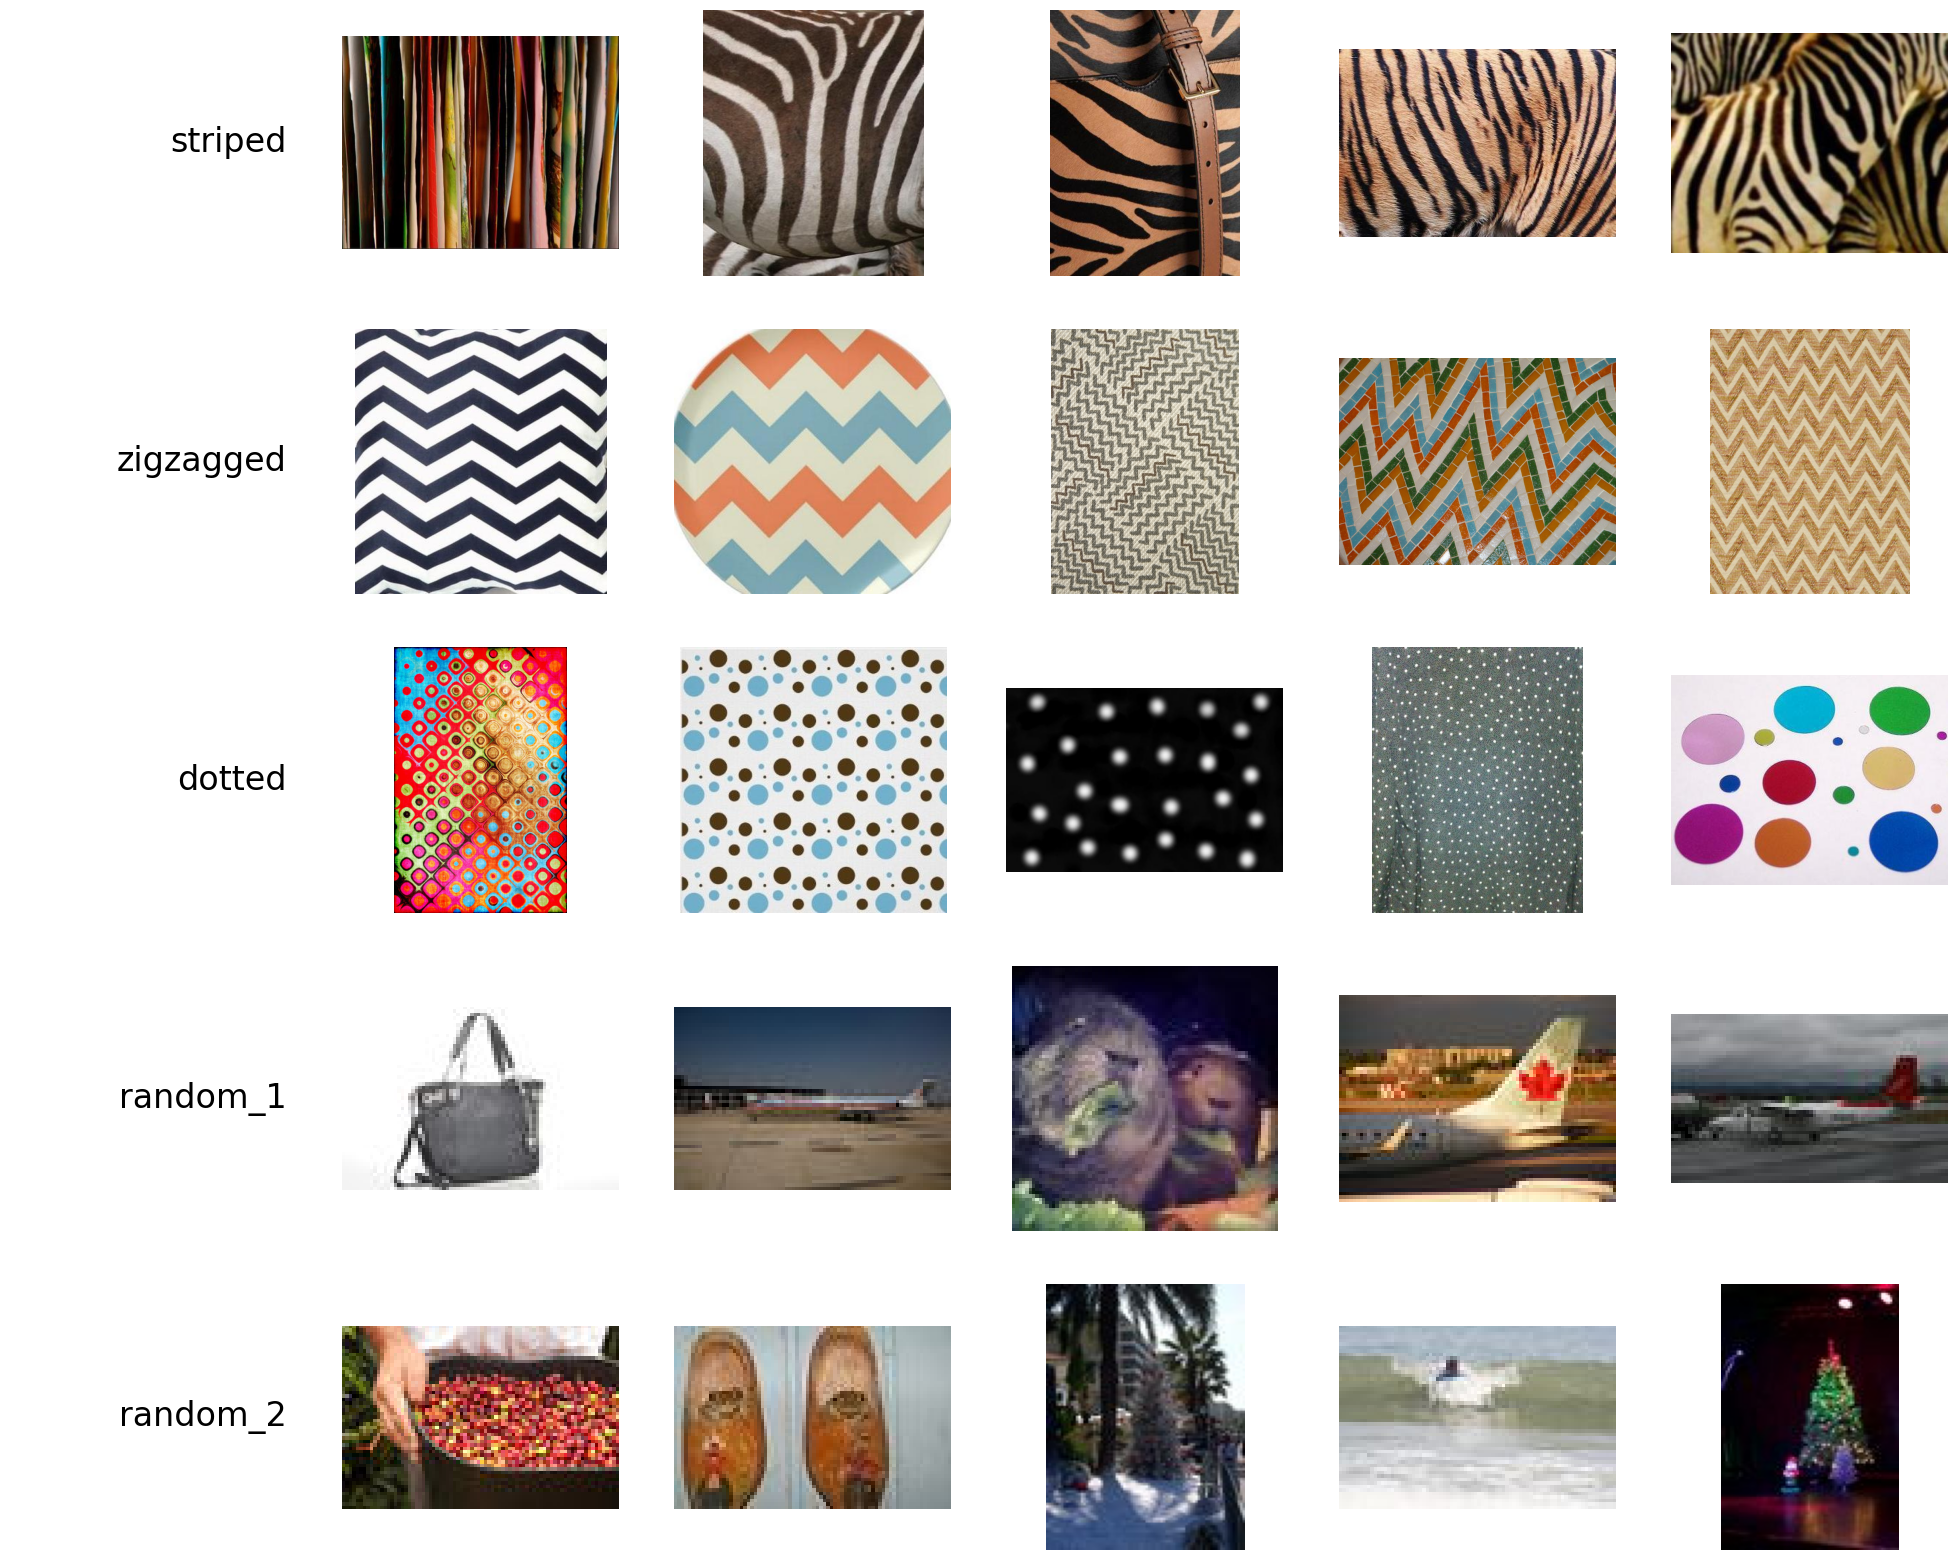

In [8]:
n_figs = 5
n_concepts = 5

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

for c, concept in enumerate([stripes_concept, zigzagged_concept, dotted_concept, random_0_concept, random_1_concept]):
    concept_path = os.path.join(concepts_path, concept.name) + "/"
    img_files = glob.glob(concept_path + '*')
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')


In [9]:
model = torchvision.models.googlenet(pretrained=True)
model = model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 45.9MB/s]


In [10]:
layers=['inception4c', 'inception4d', 'inception4e']

mytcav = TCAV(model=model,
              layers=layers,
              layer_attr_method = LayerIntegratedGradients(
                model, None, multiply_by_inputs=False))

/usr/local/lib/python3.11/dist-packages/captum/concept/_core/tcav.py:325: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  self.classifier = DefaultClassifier()


In [11]:
experimental_set_rand = [[stripes_concept, random_0_concept], [stripes_concept, random_1_concept]]


In [12]:
# Load sample images from folder
zebra_imgs = load_image_tensors('zebra', transform=False)

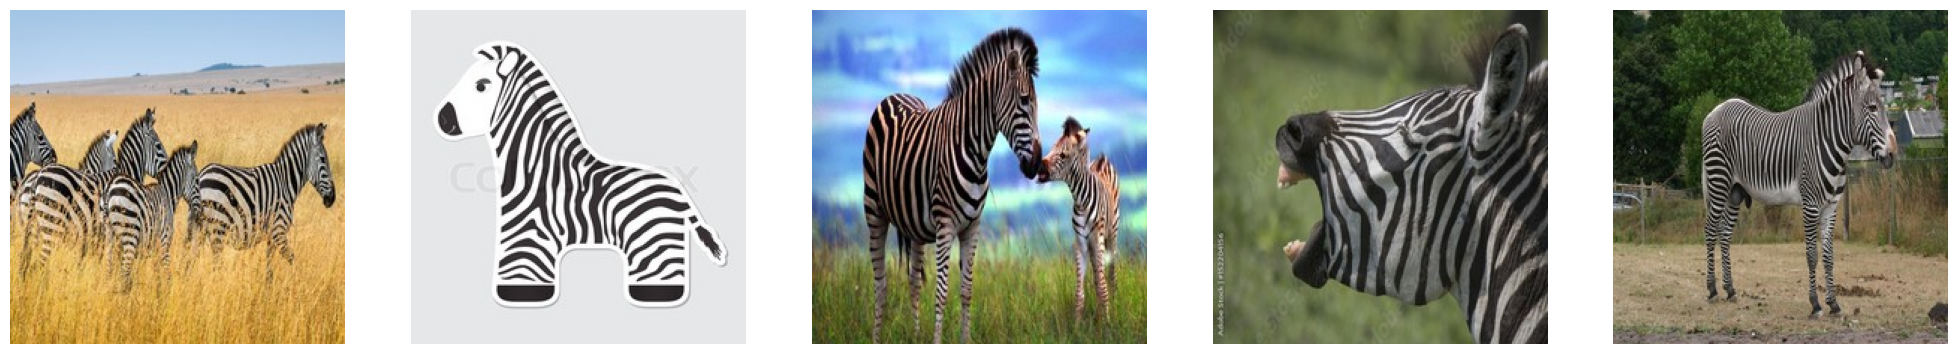

In [13]:
fig, axs = plt.subplots(1, 5, figsize = (25, 5))
axs[0].imshow(zebra_imgs[40])
axs[1].imshow(zebra_imgs[41])
axs[2].imshow(zebra_imgs[34])
axs[3].imshow(zebra_imgs[31])
axs[4].imshow(zebra_imgs[30])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')

plt.show()

In [14]:
# Load sample images from folder
zebra_tensors = torch.stack([transform(img) for img in zebra_imgs[:30]])
experimental_set_rand

[[Concept(0, 'striped'), Concept(3, 'random_1')],
 [Concept(0, 'striped'), Concept(4, 'random_2')]]

In [15]:
import torch
zebra_ind = 340
# Save original torch.load
original_load = torch.load

# Define a wrapper that forces weights_only=False
def patched_load(*args, **kwargs):
    kwargs['weights_only'] = False
    return original_load(*args, **kwargs)

# Patch torch.load
torch.load = patched_load

# Now call your TCAV interpreter
tcav_scores_w_random = mytcav.interpret(
    inputs=zebra_tensors,
    experimental_sets=experimental_set_rand,
    target=zebra_ind,
    n_steps=5
)

# (Optional) Restore torch.load afterwards
torch.load = original_load

/usr/local/lib/python3.11/dist-packages/captum/_utils/models/linear_model/train.py:409: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  bias_values = torch.FloatTensor([sklearn_model.intercept_]).to(  # type: ignore


In [17]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):

        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.show()

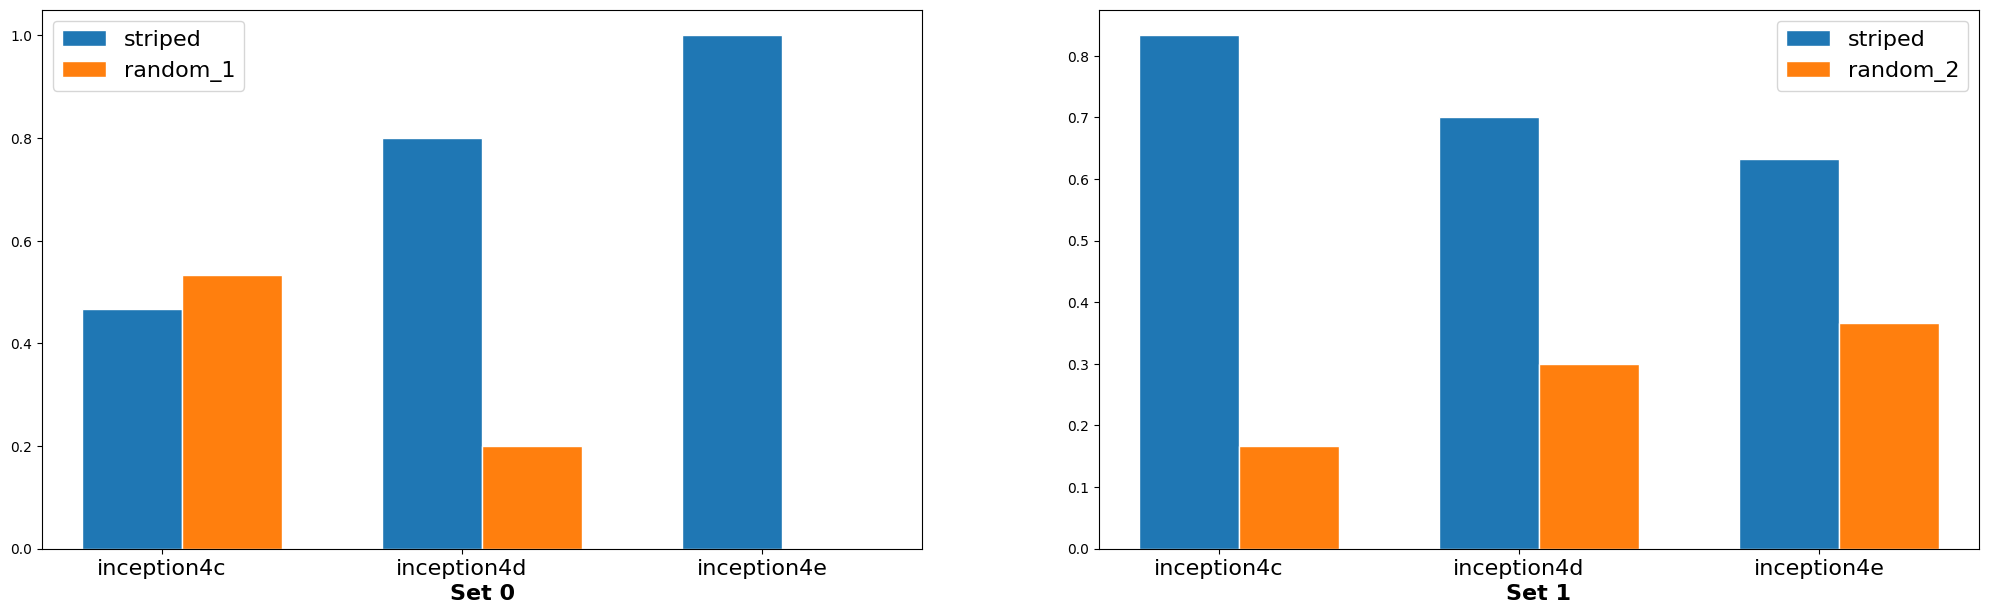

In [18]:
plot_tcav_scores(experimental_set_rand, tcav_scores_w_random)


In [19]:
experimental_set_zig_dot = [[stripes_concept, zigzagged_concept, dotted_concept]]


In [20]:
tcav_scores_w_zig_dot = mytcav.interpret(inputs=zebra_tensors,
                                         experimental_sets=experimental_set_zig_dot,
                                         target=zebra_ind,
                                         n_steps=5)


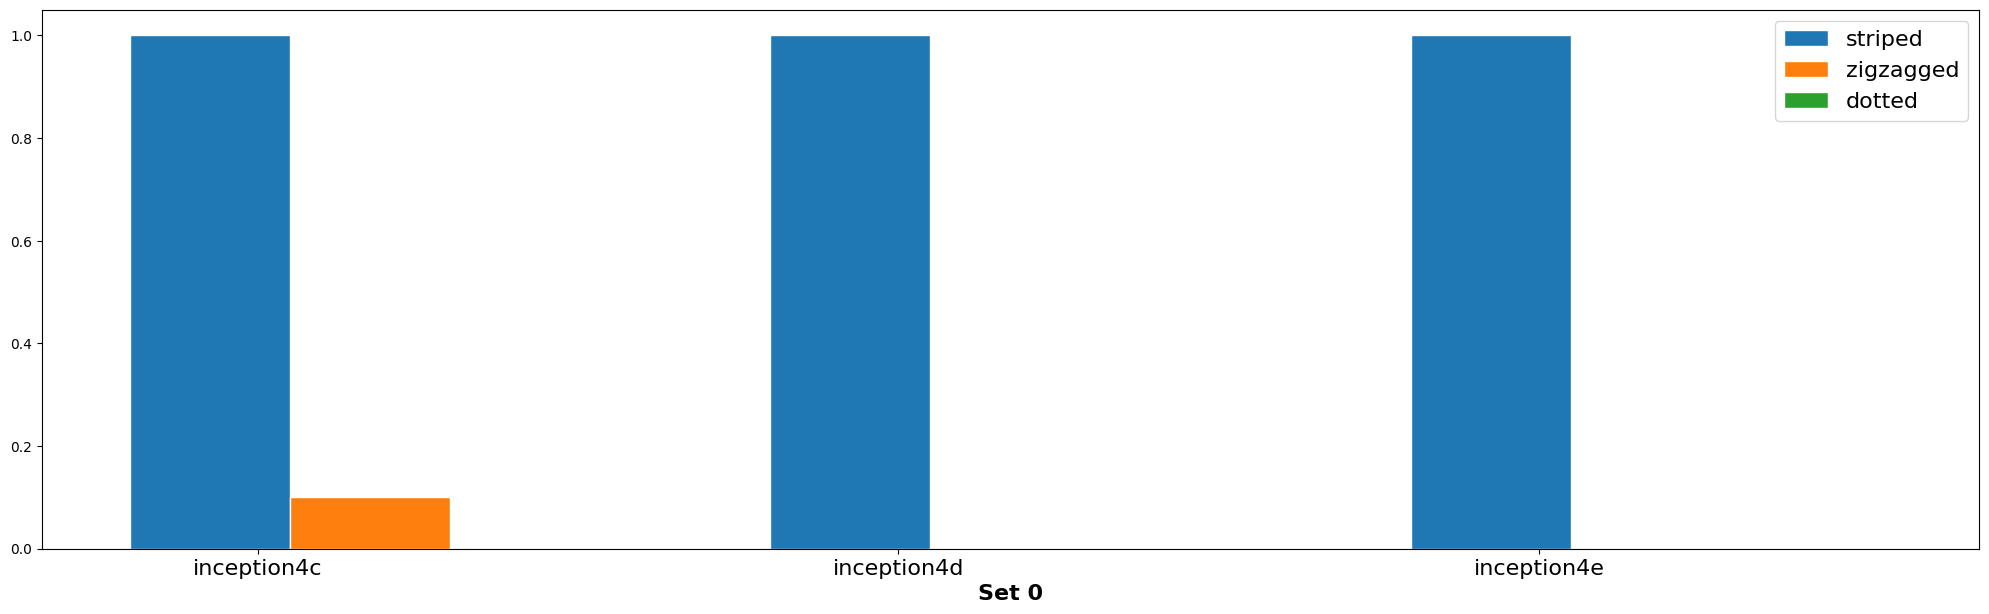

In [21]:
plot_tcav_scores(experimental_set_zig_dot, tcav_scores_w_zig_dot)


In [22]:
n = 2

random_concepts = [assemble_concept('random_' + str(i+2), i+5) for i in range(0, n)]

print(random_concepts)

experimental_sets = [[stripes_concept, random_0_concept], [stripes_concept, random_1_concept]]
experimental_sets.extend([[stripes_concept, random_concept] for random_concept in random_concepts])

experimental_sets.append([random_0_concept, random_1_concept])
experimental_sets.extend([[random_0_concept, random_concept] for random_concept in random_concepts])

experimental_sets

Concept 'random_2' found 50 image(s) in /content/drive/MyDrive/data/tcav/image/concept/random_2/
Concept 'random_3' found 54 image(s) in /content/drive/MyDrive/data/tcav/image/concept/random_3/
[Concept(5, 'random_2'), Concept(6, 'random_3')]


[[Concept(0, 'striped'), Concept(3, 'random_1')],
 [Concept(0, 'striped'), Concept(4, 'random_2')],
 [Concept(0, 'striped'), Concept(5, 'random_2')],
 [Concept(0, 'striped'), Concept(6, 'random_3')],
 [Concept(3, 'random_1'), Concept(4, 'random_2')],
 [Concept(3, 'random_1'), Concept(5, 'random_2')],
 [Concept(3, 'random_1'), Concept(6, 'random_3')]]

In [23]:
def assemble_scores(scores, experimental_sets, idx, score_layer, score_type):
    score_list = []
    for concepts in experimental_sets:
        score_list.append(scores["-".join([str(c.id) for c in concepts])][score_layer][score_type][idx])

    return score_list

In [24]:
def get_pval(scores, experimental_sets, score_layer, score_type, alpha=0.05, print_ret=False):

    P1 = assemble_scores(scores, experimental_sets, 0, score_layer, score_type)
    P2 = assemble_scores(scores, experimental_sets, 1, score_layer, score_type)

    if print_ret:
        print('P1[mean, std]: ', format_float(np.mean(P1)), format_float(np.std(P1)))
        print('P2[mean, std]: ', format_float(np.mean(P2)), format_float(np.std(P2)))

    _, pval = ttest_ind(P1, P2)

    if print_ret:
        print("p-values:", format_float(pval))

    if pval < alpha:    # alpha value is 0.05 or 5%
        relation = "Disjoint"
        if print_ret:
            print("Disjoint")
    else:
        relation = "Overlap"
        if print_ret:
            print("Overlap")

    return P1, P2, format_float(pval), relation

In [25]:
# Run TCAV
scores = mytcav.interpret(zebra_tensors, experimental_sets, zebra_ind, n_steps=5)

In [26]:
n = 4
def show_boxplots(layer, metric='sign_count'):

    def format_label_text(experimental_sets):
        concept_id_list = [exp.name if i == 0 else \
                             exp.name.split('_')[0] for i, exp in enumerate(experimental_sets[0])]
        return concept_id_list

    n_plots = 2

    fig, ax = plt.subplots(1, n_plots, figsize = (25, 7 * 1))
    fs = 18
    for i in range(n_plots):
        esl = experimental_sets[i * n : (i+1) * n]
        P1, P2, pval, relation = get_pval(scores, esl, layer, metric)

        ax[i].set_ylim([0, 1])
        ax[i].set_title(layer + "-" + metric + " (pval=" + str(pval) + " - " + relation + ")", fontsize=fs)
        ax[i].boxplot([P1, P2], showfliers=True)

        ax[i].set_xticklabels(format_label_text(esl), fontsize=fs)

    plt.show()

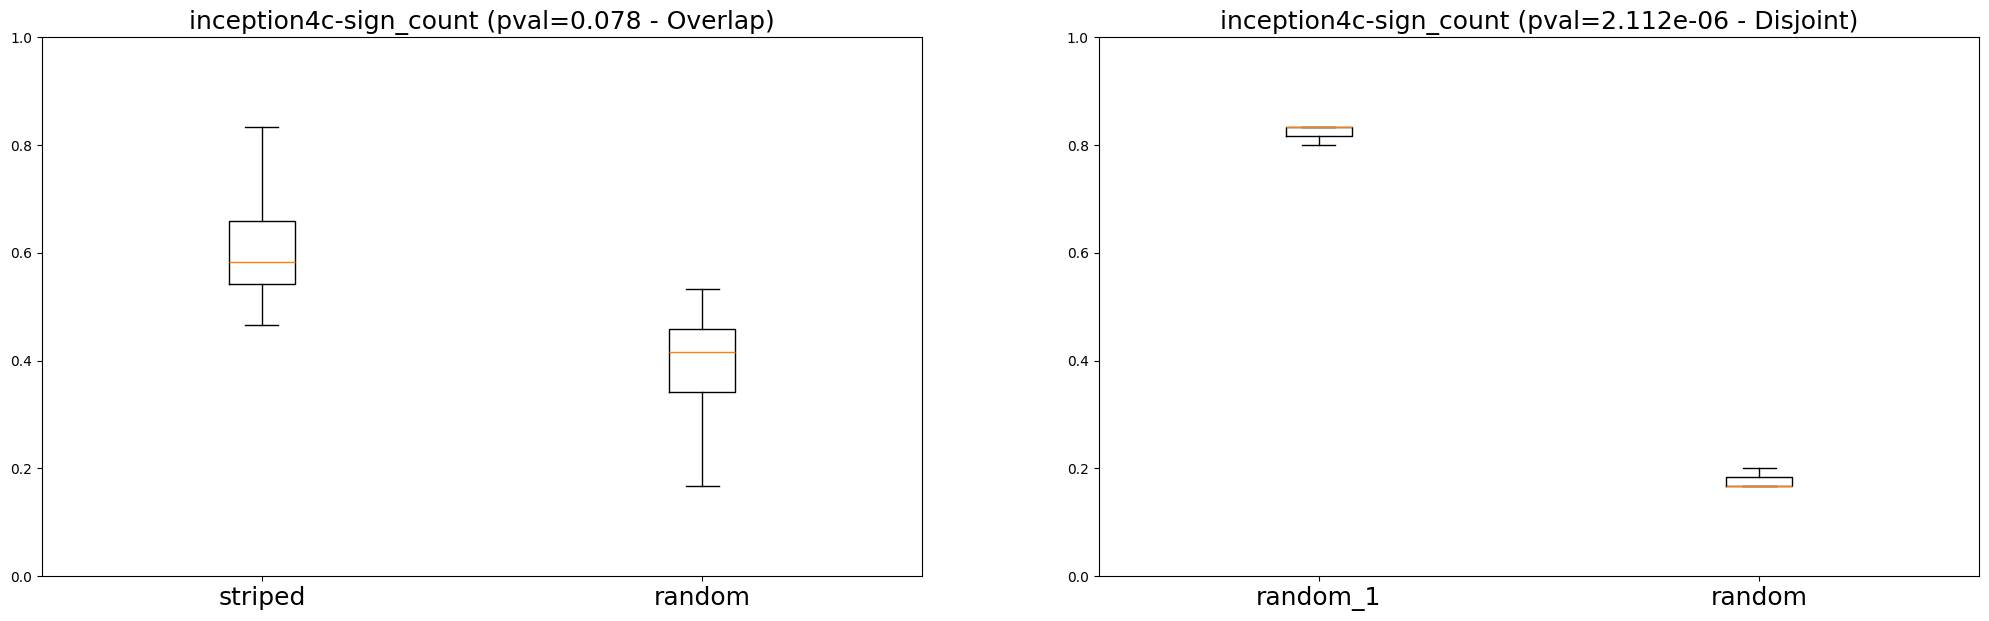

In [27]:
show_boxplots ("inception4c")

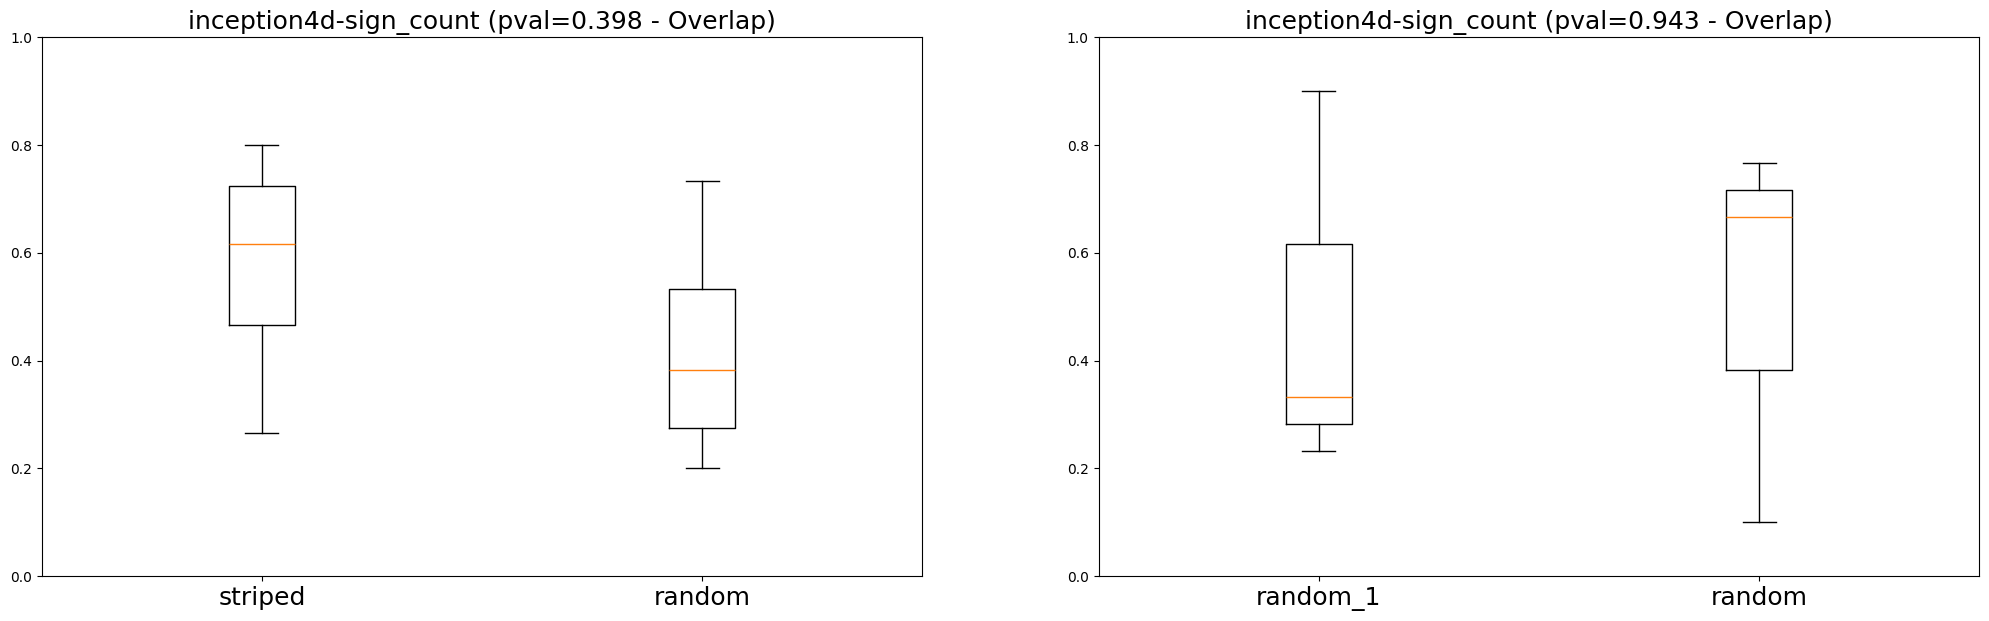

In [28]:
show_boxplots ("inception4d")


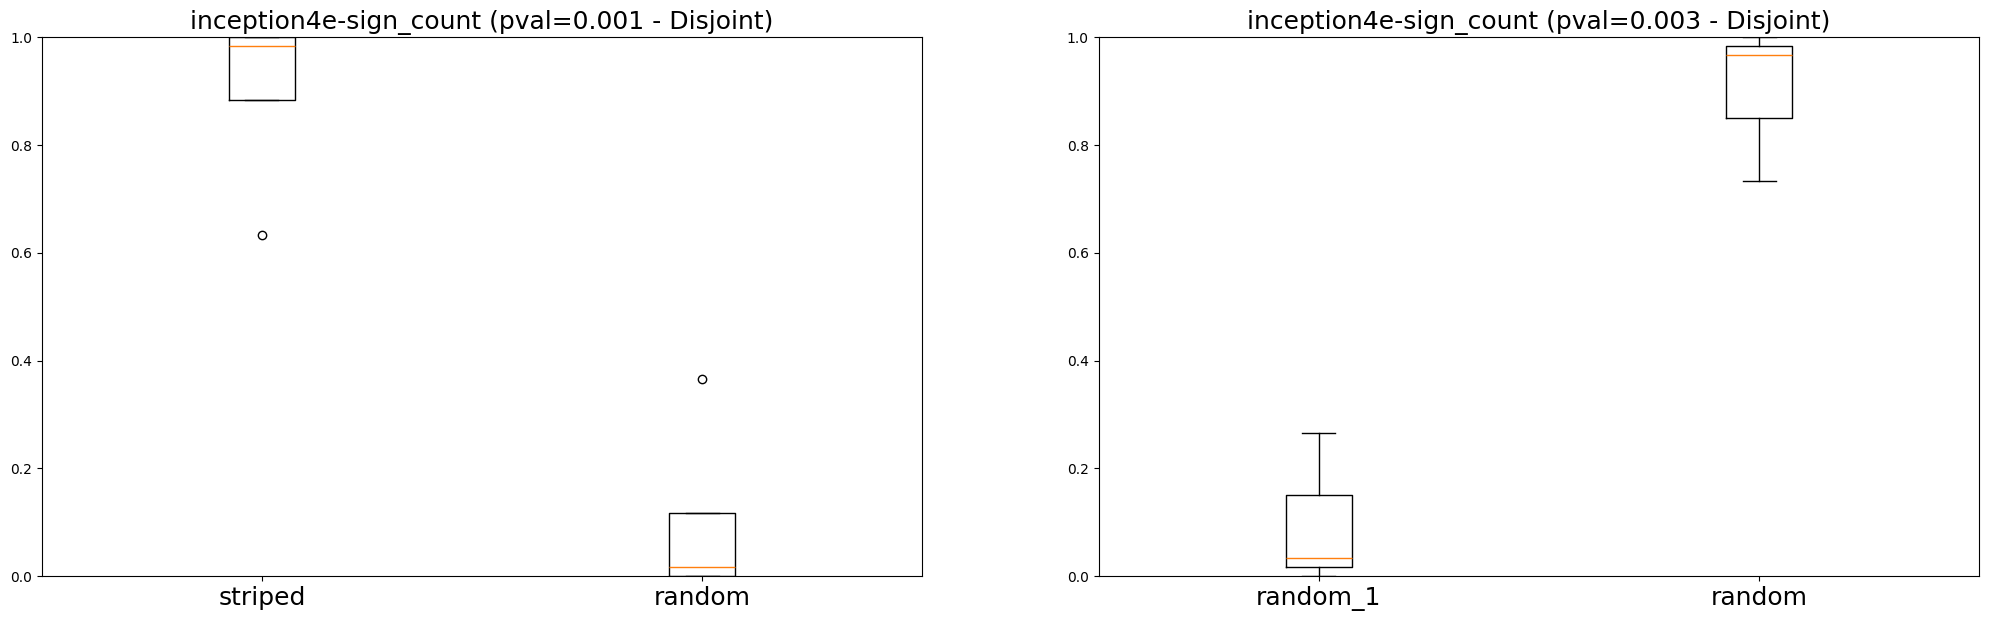

In [30]:
show_boxplots ("inception4e")
